In [2]:
%pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [4]:

%pip install matplotlib
%pip install scikit-learn
%pip install tensorflow
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


import and setup

In [5]:
%pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [1]:

import os
from tensorflow import keras
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

#paths
IMAGE_DIR = 'C:/Users\PartZ/derm-ai-assistant/data/ISIC_2018/images/ISIC2018_Task1-2_Training_Input'
MASK_DIR = 'C:/Users/PartZ/derm-ai-assistant/data/ISIC_2018/masks/ISIC2018_Task1_Training_GroundTruth'

#settings
IMG_SIZE= 128

<>:11: SyntaxWarning: invalid escape sequence '\P'
<>:11: SyntaxWarning: invalid escape sequence '\P'
C:\Users\PartZ\AppData\Local\Temp\ipykernel_6920\3035707260.py:11: SyntaxWarning: invalid escape sequence '\P'
  IMAGE_DIR = 'C:/Users\PartZ/derm-ai-assistant/data/ISIC_2018/images/ISIC2018_Task1-2_Training_Input'


load and resize images and masks

In [2]:
def load_data(IMAGE_DIR, MASK_DIR, IMG_SIZE=128):
    images = []
    masks = []

    img_names = os.listdir(IMAGE_DIR)
    img_names = [f for f in img_names if f.endswith('.jpg')]

    for name in tqdm(img_names[:1000]):
        img_path = os.path.join(IMAGE_DIR, name)
        mask_path = os.path.join(MASK_DIR, name.replace('.jpg','_segmentation.png'))


        img = cv2.imread(img_path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_SIZE,IMG_SIZE))
        mask = mask / 255.0
        mask = (mask > 0.5).astype(np.float32)
        mask = np.expand_dims(mask, axis=-1)

        images.append(img)
        masks.append(mask)
    
    return np.array(images), np.array(masks)

images, masks = load_data(IMAGE_DIR, MASK_DIR, IMG_SIZE)
print("loaded images:", images.shape)
print("loaded masks:", masks.shape)

100%|██████████| 1000/1000 [00:46<00:00, 21.64it/s]


loaded images: (1000, 128, 128, 3)
loaded masks: (1000, 128, 128, 1)


train/test split

In [3]:
x_train, x_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

Unet

In [4]:

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return ((2. * intersection + smooth)/
            (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth))

def conv_block(input, num_filters):
    x= keras.layers.Conv2D(num_filters, 3, padding="same", activation="relu")(input)
    x = keras.layers.Conv2D(num_filters, 3, padding="same", activation="relu")(x)
    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = keras.layers.MaxPooling2D((2,2))(x)
    return x,p

def decoder_block(input, skip, num_filters):
    x = keras.layers.Conv2DTranspose(num_filters, (2,2), strides=2, padding="same")(input)
    x = keras.layers.concatenate([x, skip])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = keras.Input(shape=input_shape)

    #encoder
    s1, p1 = encoder_block(inputs, 64)
    s2,p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2,256)

    #bottleneck
    b = conv_block(p3, 512)

    #decoder
    d3 = decoder_block(b, s3, 512)
    d2 = decoder_block(d3 , s2, 128)
    d1 = decoder_block(d2, s1, 64)

    outputs = keras.layers.Conv2D(1,(1,1),padding="same", activation="sigmoid")(d1)

    return keras.Model(inputs, outputs)

model = build_unet((IMG_SIZE,IMG_SIZE,3))
model.compile(
    optimizer= keras.optimizers.Adam(learning_rate=1e-4), 
    loss= tf.keras.losses.BinaryCrossentropy(from_logits=False), 
    metrics=[dice_coef]),
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  1,049,088 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 768)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │  3,539,456 │ concatenate[0][0] │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_8[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 64, 64,    │    262,272 │ conv2d_9[0][0]  

 Total params: 12,482,241 (47.62 MB)

 Trainable params: 12,482,241 (47.62 MB)

 Non-trainable params: 0 (0.00 B)

Training and vizualization

In [5]:
x_train = x_train.astype(np.float32)
y_train = y_train.astype(np.float32)
x_val = x_val.astype(np.float32)
y_val = y_val.astype(np.float32)

def augment(image, mask):
    # Random horizontal flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    # Random vertical flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)
    # Random rotation (0, 90, 180, 270 degrees)
    k = tf.random.uniform((), minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    mask = tf.image.rot90(mask, k)
    return image, mask

BATCH_SIZE = 16

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(x_train))
train_dataset = train_dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    train_dataset,
    validation_data= val_dataset,
    epochs=50,
    callbacks=[callback],
    verbose=1
)
def plot_augmented_samples(dataset, num_samples=5):
    for images, masks in dataset.take(1):
        for i in range(num_samples):
            plt.figure(figsize=(8, 4))
            plt.subplot(1, 2, 1)
            plt.title("Augmented Image")
            plt.imshow(images[i].numpy())
            plt.axis("off")
            plt.subplot(1, 2, 2)
            plt.title("Augmented Mask")
            plt.imshow(masks[i].numpy().squeeze(), cmap='gray')
            plt.axis("off")
            plt.show()

def plot_sample(idx, x=x_train, y=y_train):
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 4, 1)
    plt.title("Image")
    plt.imshow(x[idx])
    plt.axis("off")
    plt.subplot(1, 4, 2)
    plt.title("Ground Truth")
    plt.imshow(y[idx].squeeze(), cmap='gray')
    plt.axis("off")
    pred = model.predict(np.expand_dims(x[idx], axis=0))[0]
    print("Prediction stats: min =", pred.min(), "max =", pred.max(), "mean =", pred.mean())
    plt.subplot(1, 4, 3)
    plt.title("Prediction (prob)")
    plt.imshow(pred.squeeze(), cmap='gray')
    plt.axis("off")
    plt.subplot(1, 4, 4)
    plt.title("Prediction (binary)")
    plt.imshow((pred.squeeze() > 0.5).astype(np.uint8), cmap='gray')
    plt.axis("off")
    plt.tight_layout()
    plt.show()

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 390s 8s/step - dice_coef: 0.3307 - loss: 0.6244 - val_dice_coef: 0.3444 - val_loss: 0.4854
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 402s 8s/step - dice_coef: 0.3949 - loss: 0.4643 - val_dice_coef: 0.5100 - val_loss: 0.3783
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 378s 8s/step - dice_coef: 0.5746 - loss: 0.3683 - val_dice_coef: 0.6579 - val_loss: 0.3128
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 368s 7s/step - dice_coef: 0.6725 - loss: 0.2975 - val_dice_coef: 0.7218 - val_loss: 0.2721
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 520s 10s/step - dice_coef: 0.7014 - loss: 0.2676 - val_dice_coef: 0.7508 - val_loss: 0.2687
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 374s 7s/step - dice_coef: 0.7438 - loss: 0.2329 - val_dice_coef: 0.7793 - val_loss: 0.2310
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 373s 7s/step - dice_coef: 0.7795 - loss: 0.1959 - val_dice_coef: 0.8207 - val_loss: 0.2228
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 374s 7s/step - dice_coef: 0.7935 - loss: 0.1890 - val_dice

plot test

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
Prediction stats: min = 3.536667e-05 max = 0.9999744 mean = 0.12920041


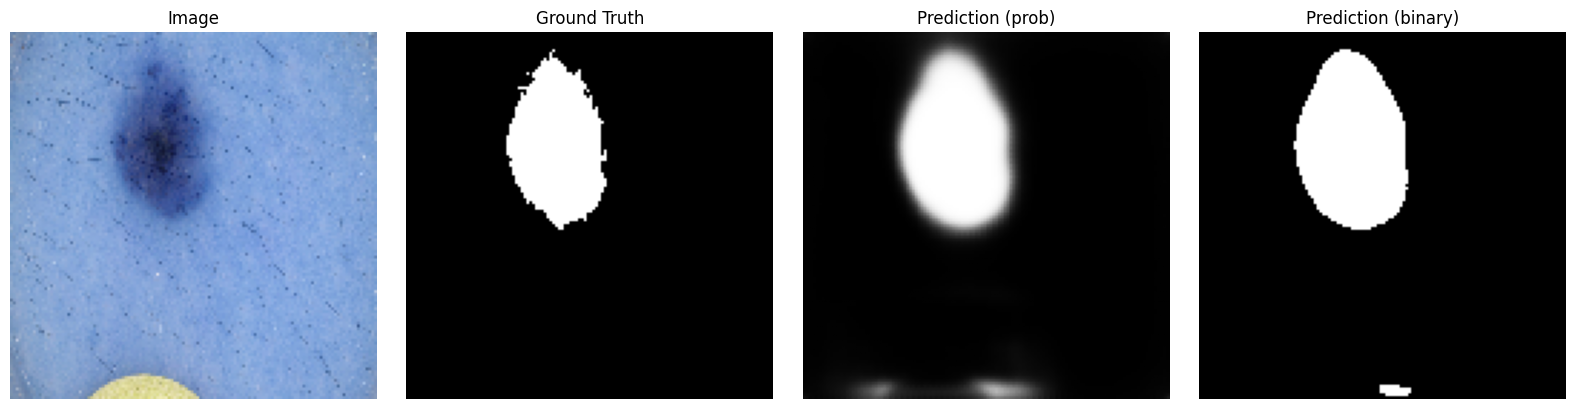

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
Prediction stats: min = 3.9442502e-06 max = 1.0 mean = 0.518566


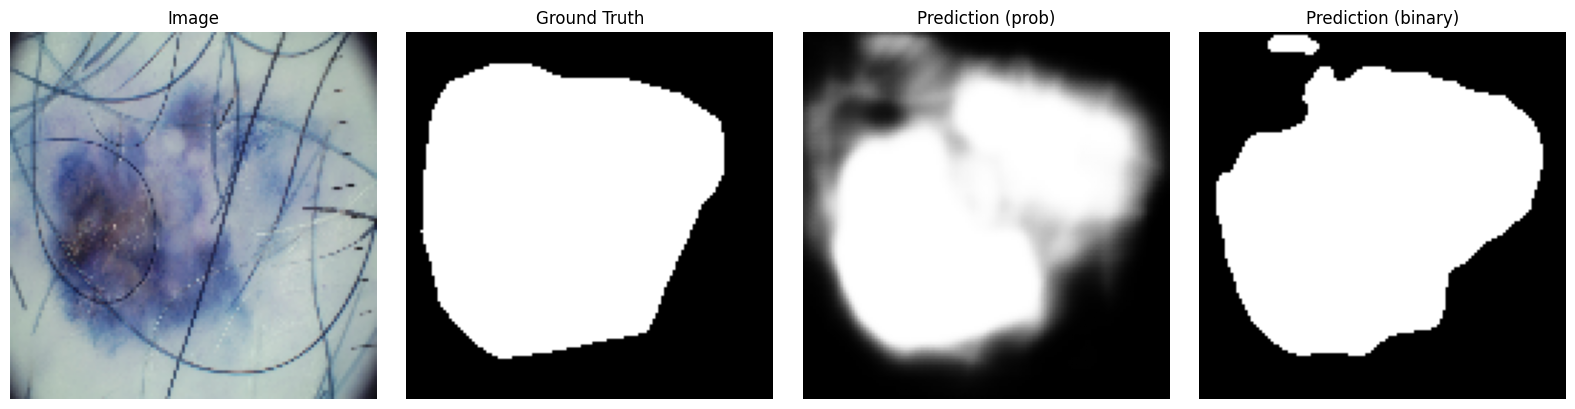

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
Prediction stats: min = 0.0005496673 max = 0.9999993 mean = 0.8619344


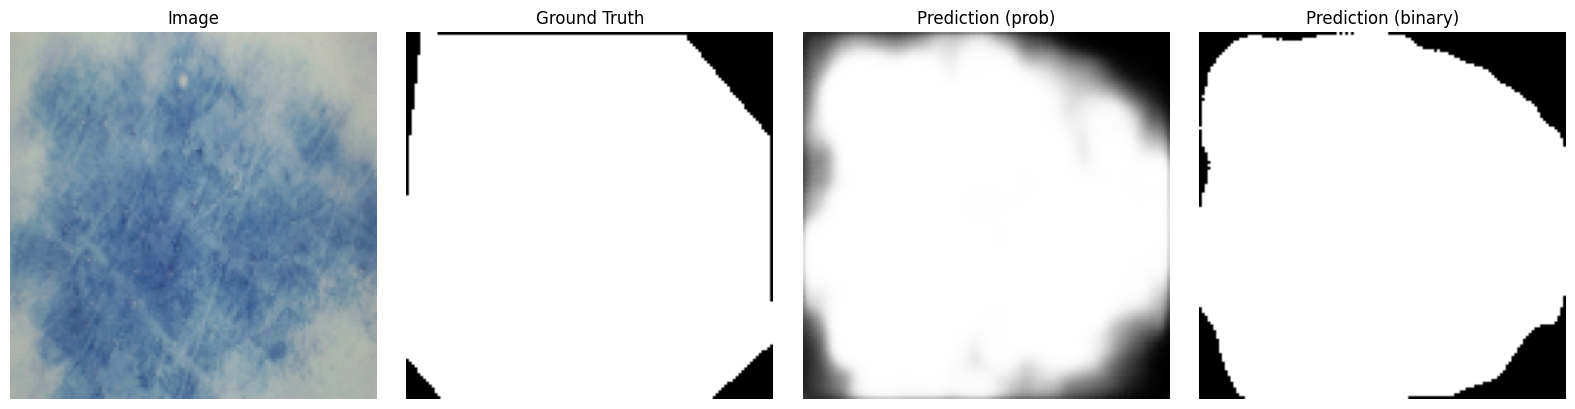

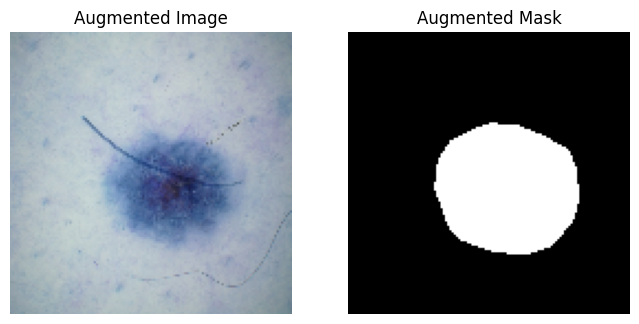

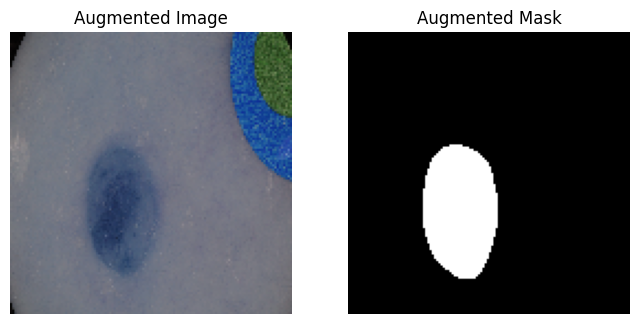

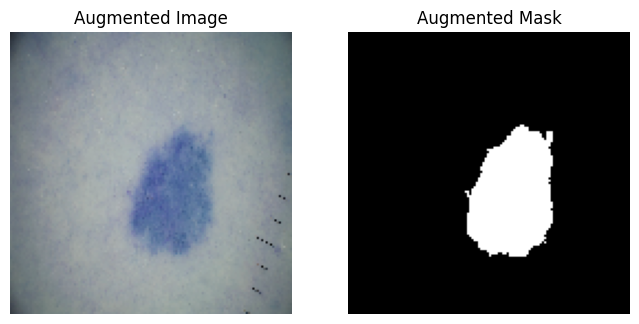

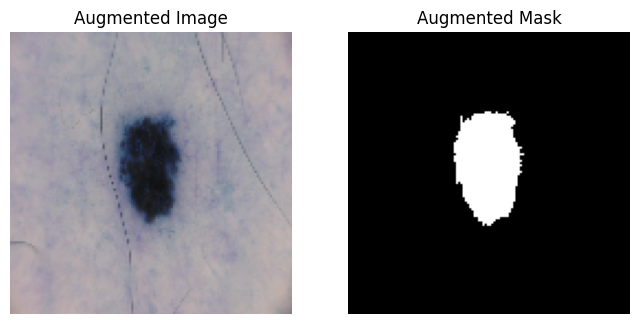

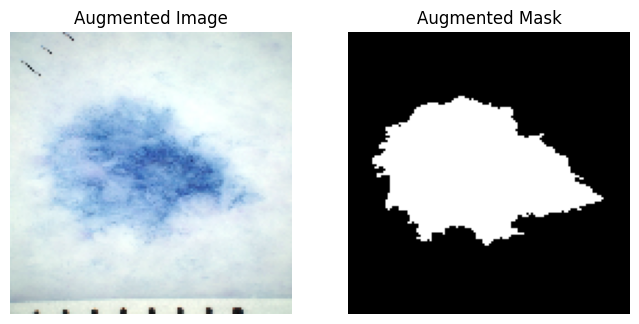

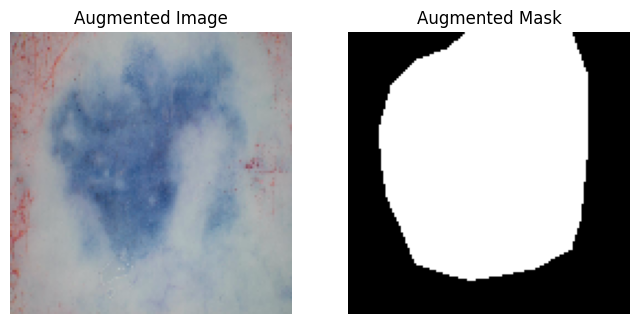

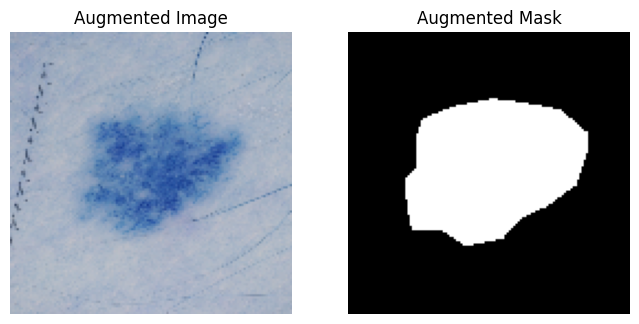

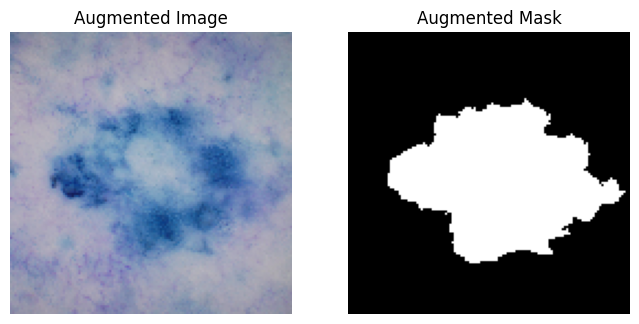

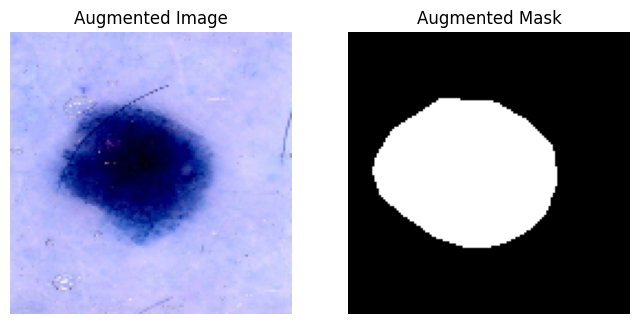

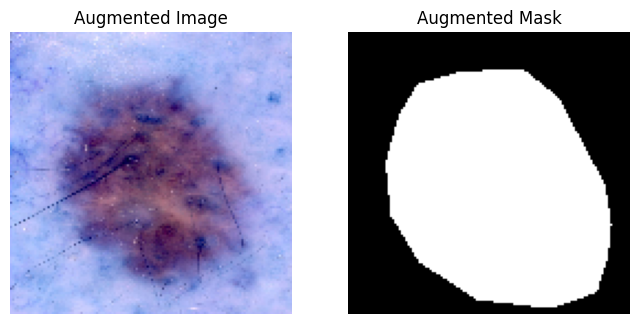

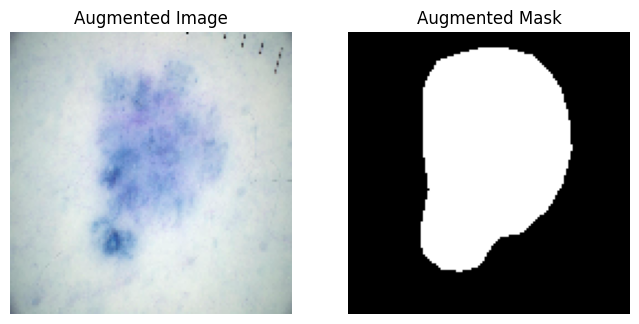

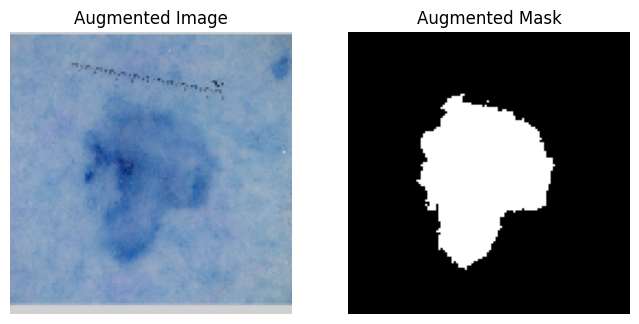

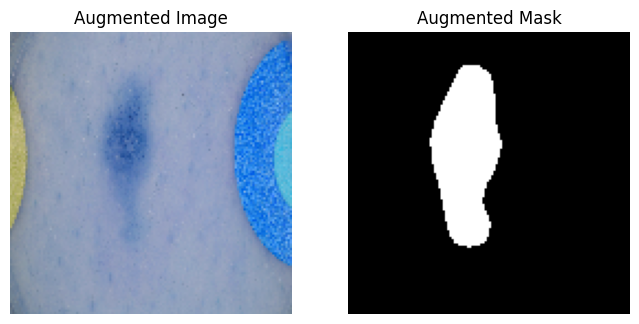

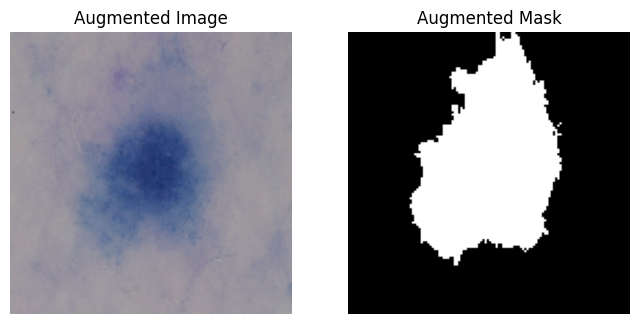

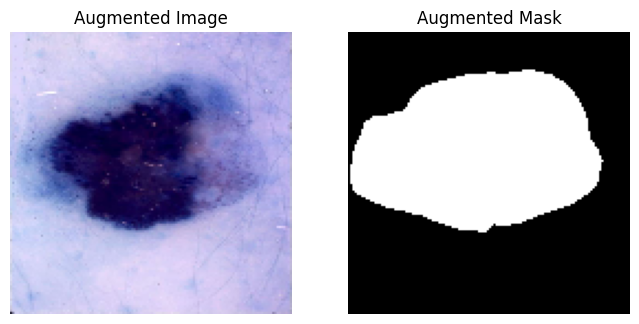

In [6]:

for i in range(3):
    plot_sample(i, x = x_val, y=y_val)
    
for i in range(3):
    plot_augmented_samples(train_dataset)

evaluate and save

In [7]:
model.save("C:/Users/PartZ/derm-ai-assistant/backend/model/skin_segmentation_unet_fine_tuned_augmented2.keras")